# Data Analysis

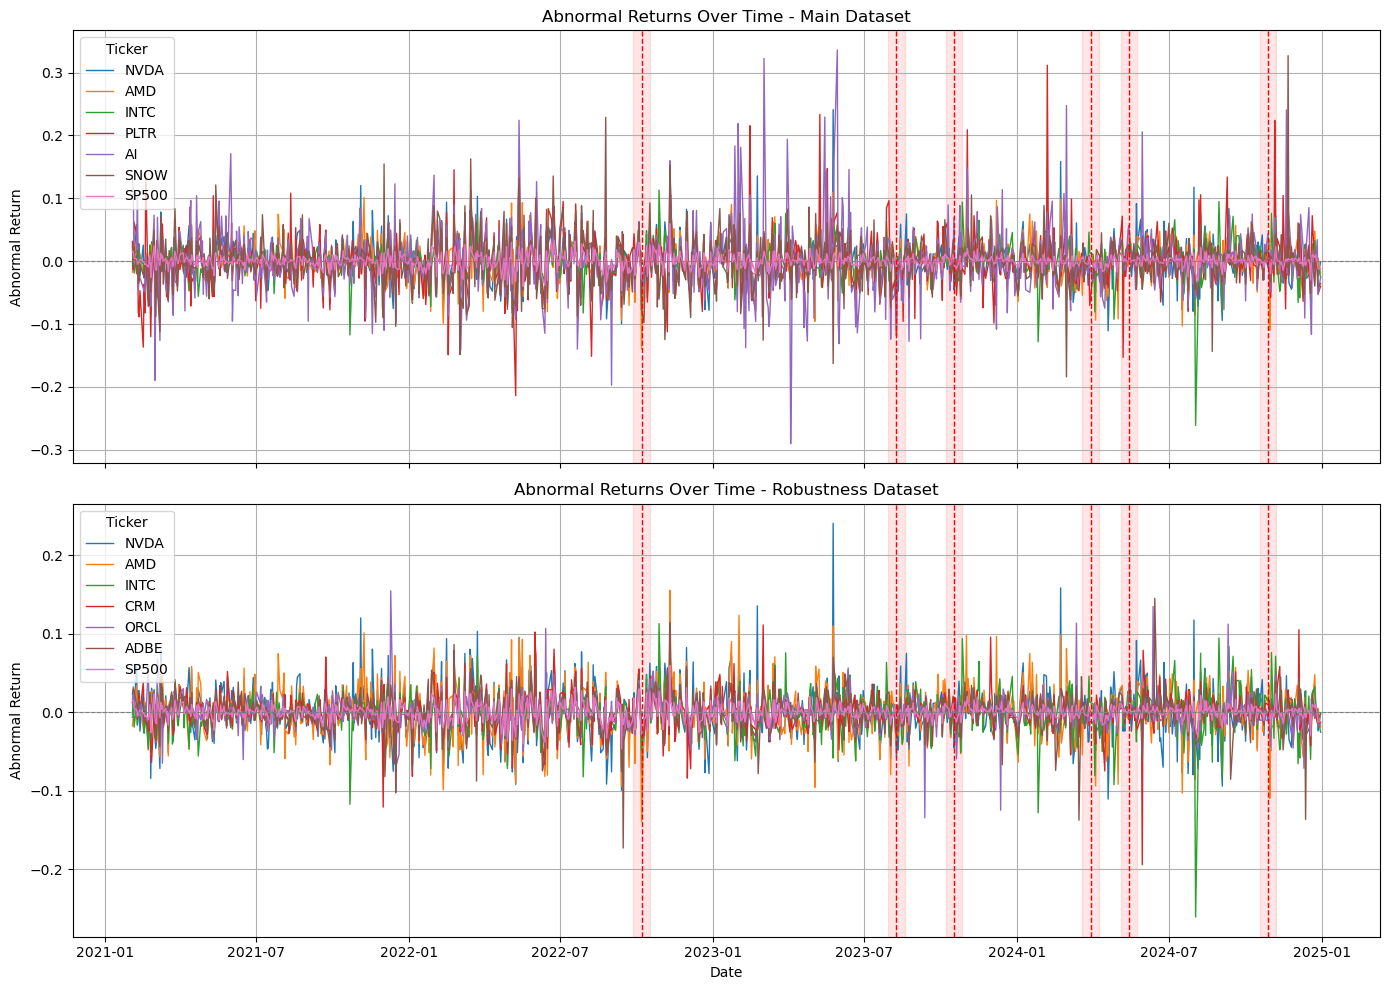

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load two datasets ===
main_df = pd.read_csv("main_df.csv", parse_dates=["Date", "event_date"])
robust_df = pd.read_csv("robust_df.csv", parse_dates=["Date", "event_date"])

# === Define policy event dictionary ===
event_dict = {
    "2022_export_control": pd.to_datetime("2022-10-07"),
    "2023_investment_ban": pd.to_datetime("2023-08-09"),
    "2023_export_expansion": pd.to_datetime("2023-10-17"),
    "2024_export_tightening": pd.to_datetime("2024-03-29"),
    "2024_tariff_increase": pd.to_datetime("2024-05-14"),
    "2024_investment_finalization": pd.to_datetime("2024-10-28"),
}

# === Create subplots ===
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Function to plot abnormal returns with event shading
def plot_ar_series(ax, df, title):
    tickers = df["ticker"].unique()
    for ticker in tickers:
        sub = df[df["ticker"] == ticker]
        ax.plot(sub["Date"], sub["abnormal_return"], label=ticker, linewidth=1)
    
    # Add event lines and shaded windows
    for event_date in event_dict.values():
        ax.axvline(event_date, color='red', linestyle='--', linewidth=1)
        ax.axvspan(event_date - pd.Timedelta(days=10),
                   event_date + pd.Timedelta(days=10),
                   color='red', alpha=0.1)
    
    ax.set_title(title)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_ylabel("Abnormal Return")
    ax.grid(True)
    ax.legend(title="Ticker", loc="upper left")

# === Plot main_df (top) and robust_df (bottom) ===
plot_ar_series(axs[0], main_df, "Abnormal Returns Over Time - Main Dataset")
plot_ar_series(axs[1], robust_df, "Abnormal Returns Over Time - Robustness Dataset")

# Final plot formatting
plt.xlabel("Date")
plt.tight_layout()
plt.show()


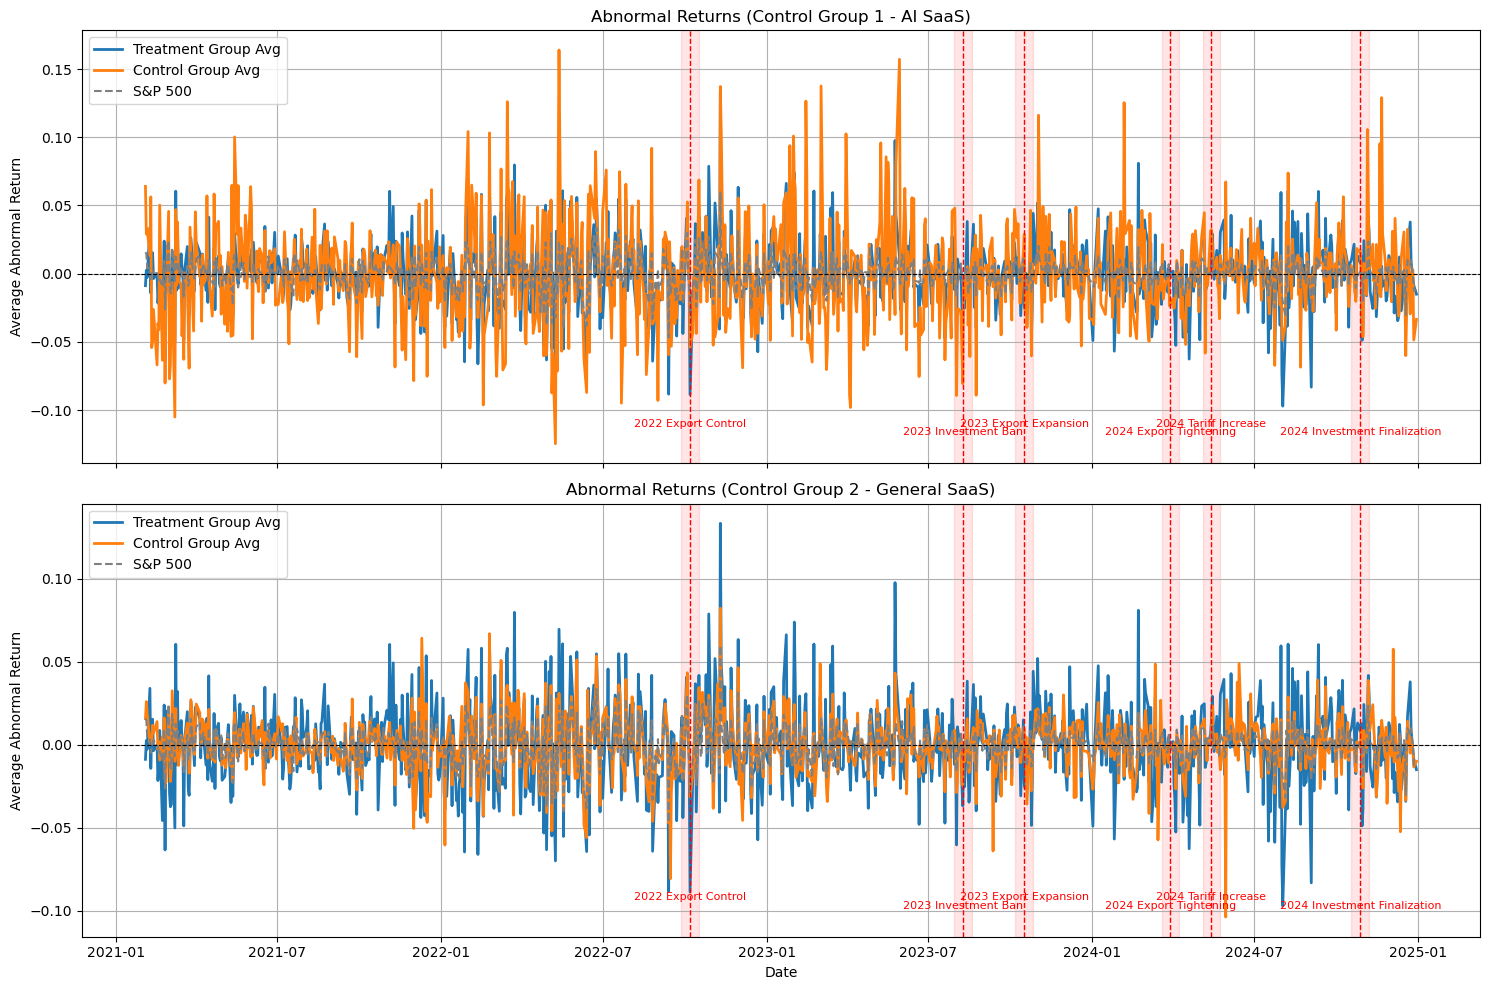

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load datasets ===
main_df = pd.read_csv("main_df.csv", parse_dates=["Date", "event_date"])
robust_df = pd.read_csv("robust_df.csv", parse_dates=["Date", "event_date"])

# === Define policy event dictionary ===
event_dict = {
    "2022 Export Control": pd.to_datetime("2022-10-07"),
    "2023 Investment Ban": pd.to_datetime("2023-08-09"),
    "2023 Export Expansion": pd.to_datetime("2023-10-17"),
    "2024 Export Tightening": pd.to_datetime("2024-03-29"),
    "2024 Tariff Increase": pd.to_datetime("2024-05-14"),
    "2024 Investment Finalization": pd.to_datetime("2024-10-28"),
}

# === Define groups ===
treatment_group = ["NVDA", "AMD", "INTC"]
control_main = ["PLTR", "AI", "SNOW"]
control_robust = ["CRM", "ORCL", "ADBE"]
benchmark = "SP500"

# === Reusable plot function with horizontal, staggered event labels ===
def plot_group_avg(ax, df, control_group, title):
    # Assign group labels
    df["Group"] = df["ticker"].apply(
        lambda x: "Treatment" if x in treatment_group else 
                  "Control" if x in control_group else 
                  "SP500" if x == benchmark else None
    )
    df = df[df["Group"].notna()]

    # Compute group-level average abnormal return
    avg_df = df.groupby(["Date", "Group"])["abnormal_return"].mean().reset_index()
    avg_pivot = avg_df.pivot(index="Date", columns="Group", values="abnormal_return")

    # Plot average return lines
    if "Treatment" in avg_pivot.columns:
        ax.plot(avg_pivot.index, avg_pivot["Treatment"], label="Treatment Group Avg", linewidth=2)
    if "Control" in avg_pivot.columns:
        ax.plot(avg_pivot.index, avg_pivot["Control"], label="Control Group Avg", linewidth=2)
    if "SP500" in avg_pivot.columns:
        ax.plot(avg_pivot.index, avg_pivot["SP500"], label="S&P 500", color='gray', linestyle='--')

    # Add vertical lines and shaded event windows
    for i, (label, date) in enumerate(event_dict.items()):
        ax.axvline(date, color='red', linestyle='--', linewidth=1)
        ax.axvspan(date - pd.Timedelta(days=10), date + pd.Timedelta(days=10), color='red', alpha=0.1)
        # Add horizontal, staggered label
        y_pos = 0.08 if i % 2 == 0 else 0.06
        ax.text(date, y_pos, label, fontsize=8, color='red', rotation=0,
                ha='center', va='bottom', transform=ax.get_xaxis_transform())

    ax.set_title(title)
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_ylabel("Average Abnormal Return")
    ax.grid(True)
    ax.legend()

# === Create subplot canvas ===
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot main control group (AI-focused SaaS)
plot_group_avg(axs[0], main_df, control_main, "Abnormal Returns (Control Group 1 - AI SaaS)")

# Plot robust control group (General SaaS)
plot_group_avg(axs[1], robust_df, control_robust, "Abnormal Returns (Control Group 2 - General SaaS)")

# Final formatting
plt.xlabel("Date")
plt.tight_layout()
plt.show()


We find that Control Group 2—comprising large software firms such as Salesforce, Oracle, and Adobe—exhibits greater stability in abnormal returns and closer alignment with the market benchmark. This group appears less sensitive to AI and semiconductor-specific policy shocks, making it a more appropriate counterfactual for isolating the causal effect of hardware dependence. Therefore, we use Control Group 2 as our primary comparison group in the main Difference-in-Differences analysis.


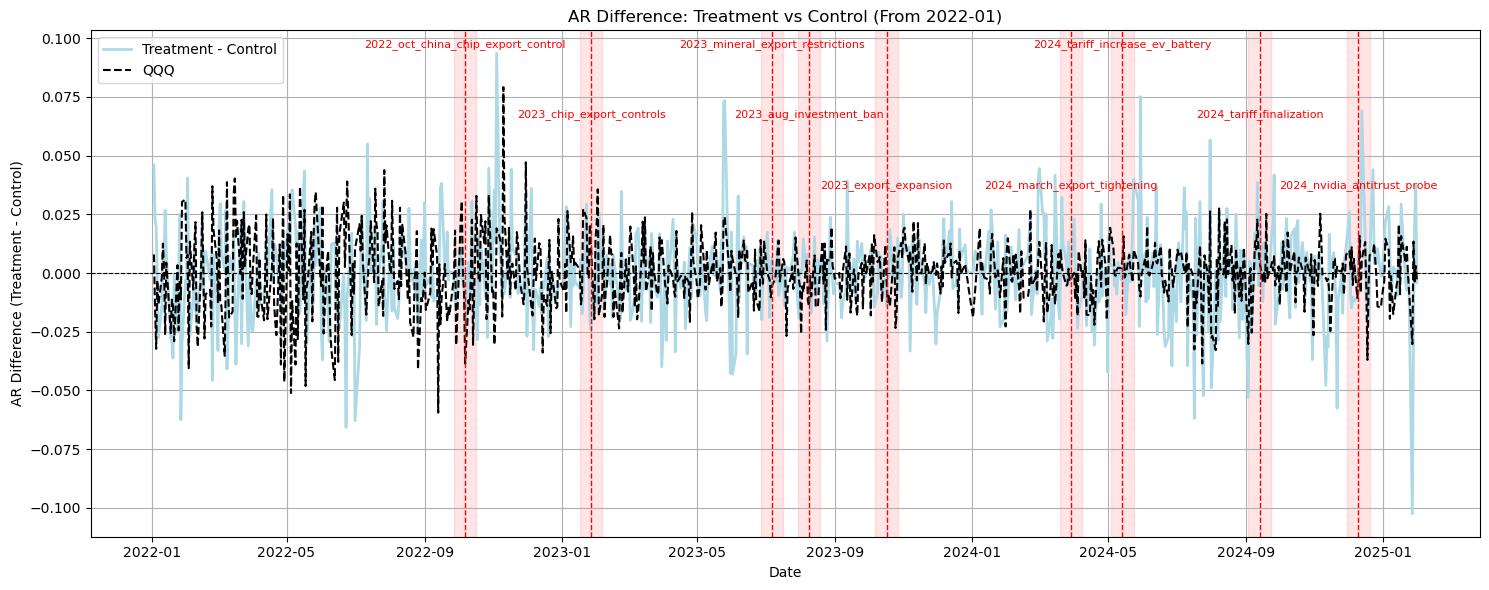

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load robust dataset ===
final_df = pd.read_csv("final_df.csv", parse_dates=["Date", "event_date"])

# === Define groups ===
treatment_group = ["NVDA", "AMD", "INTC", "MU", "AVGO", "QCOM", "MRVL", "TSM"]
control_group = ['CRM','ORCL','ADBE','NOW','CRWD','MDB','INTU','SNOW']
benchmark = "QQQ"

# === Define policy event dictionary ===
event_dict = {
    "2022_oct_china_chip_export_control": pd.to_datetime("2022-10-07"),  # Biden administration restricts advanced AI chip exports to China
    "2023_chip_export_controls": pd.to_datetime("2023-01-27"),  # US and EU tighten controls on semiconductor technology exports to China
    "2023_export_expansion": pd.to_datetime("2023-10-17"),  # US expands export restrictions on semiconductors
    
    "2023_mineral_export_restrictions": pd.to_datetime("2023-07-07"),  # China restricts critical mineral exports
    "2023_aug_investment_ban": pd.to_datetime("2023-08-09"),  # Biden signs executive order banning investments in Chinese AI/semiconductors
    "2024_march_export_tightening": pd.to_datetime("2024-03-29"),  # US tightens export licensing rules for AI semiconductors
    "2024_tariff_increase_ev_battery": pd.to_datetime("2024-05-14"),  # US raises tariffs on EV batteries, solar panels, and metals
    "2024_tariff_finalization": pd.to_datetime("2024-09-13"),  # US finalizes higher tariffs
    "2024_nvidia_antitrust_probe": pd.to_datetime("2024-12-10"),  # China launches antitrust investigation into Nvidia
}

# === Assign group labels ===
final_df["Group"] = final_df["ticker"].apply(
    lambda x: "Treatment" if x in treatment_group else 
              "Control" if x in control_group else 
              "QQQ" if x == benchmark else None
)
final_df = final_df[final_df["Group"].notna()]

# === Compute group-level average AR ===
avg_df = final_df.groupby(["Date", "Group"])["abnormal_return"].mean().reset_index()
avg_pivot = avg_df.pivot(index="Date", columns="Group", values="abnormal_return").dropna()

# === Compute difference: Treatment - Control ===
avg_pivot["Treatment_Minus_Control"] = avg_pivot["Treatment"] - avg_pivot["Control"]

# === Plotting ===
# === Filter data after January 2022 ===
start_date = pd.to_datetime("2022-01-01")
avg_pivot = avg_pivot[avg_pivot.index >= start_date]

# === Plotting ===
plt.figure(figsize=(15, 6))

# Plot Treatment - Control difference
plt.plot(avg_pivot.index, avg_pivot["Treatment_Minus_Control"],
         label="Treatment - Control", color="lightblue", linewidth=2)

# Plot QQQ benchmark
if "QQQ" in avg_pivot.columns:
    plt.plot(avg_pivot.index, avg_pivot["QQQ"],
             label="QQQ", color="black", linestyle="--")

# Add event lines (filtered to show only events after start_date)
for i, (event_label, event_date) in enumerate(event_dict.items()):
    if event_date >= start_date:  
        plt.axvline(event_date, color='red', linestyle='--', linewidth=1)
        plt.axvspan(event_date - pd.Timedelta(days=10), event_date + pd.Timedelta(days=10),
                    color='red', alpha=0.1)
        
        if i % 3 == 0:
            y_pos = 0.095
        elif i % 3 == 1:
            y_pos = 0.065
        else:
            y_pos = 0.035

        plt.text(event_date, y_pos, event_label, rotation=0, fontsize=8, color='red',
                 horizontalalignment='center', verticalalignment='bottom')

# Final touches
plt.title(f"AR Difference: Treatment vs Control (From {start_date.strftime('%Y-%m')})")
plt.xlabel("Date")
plt.ylabel("AR Difference (Treatment - Control)")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# new

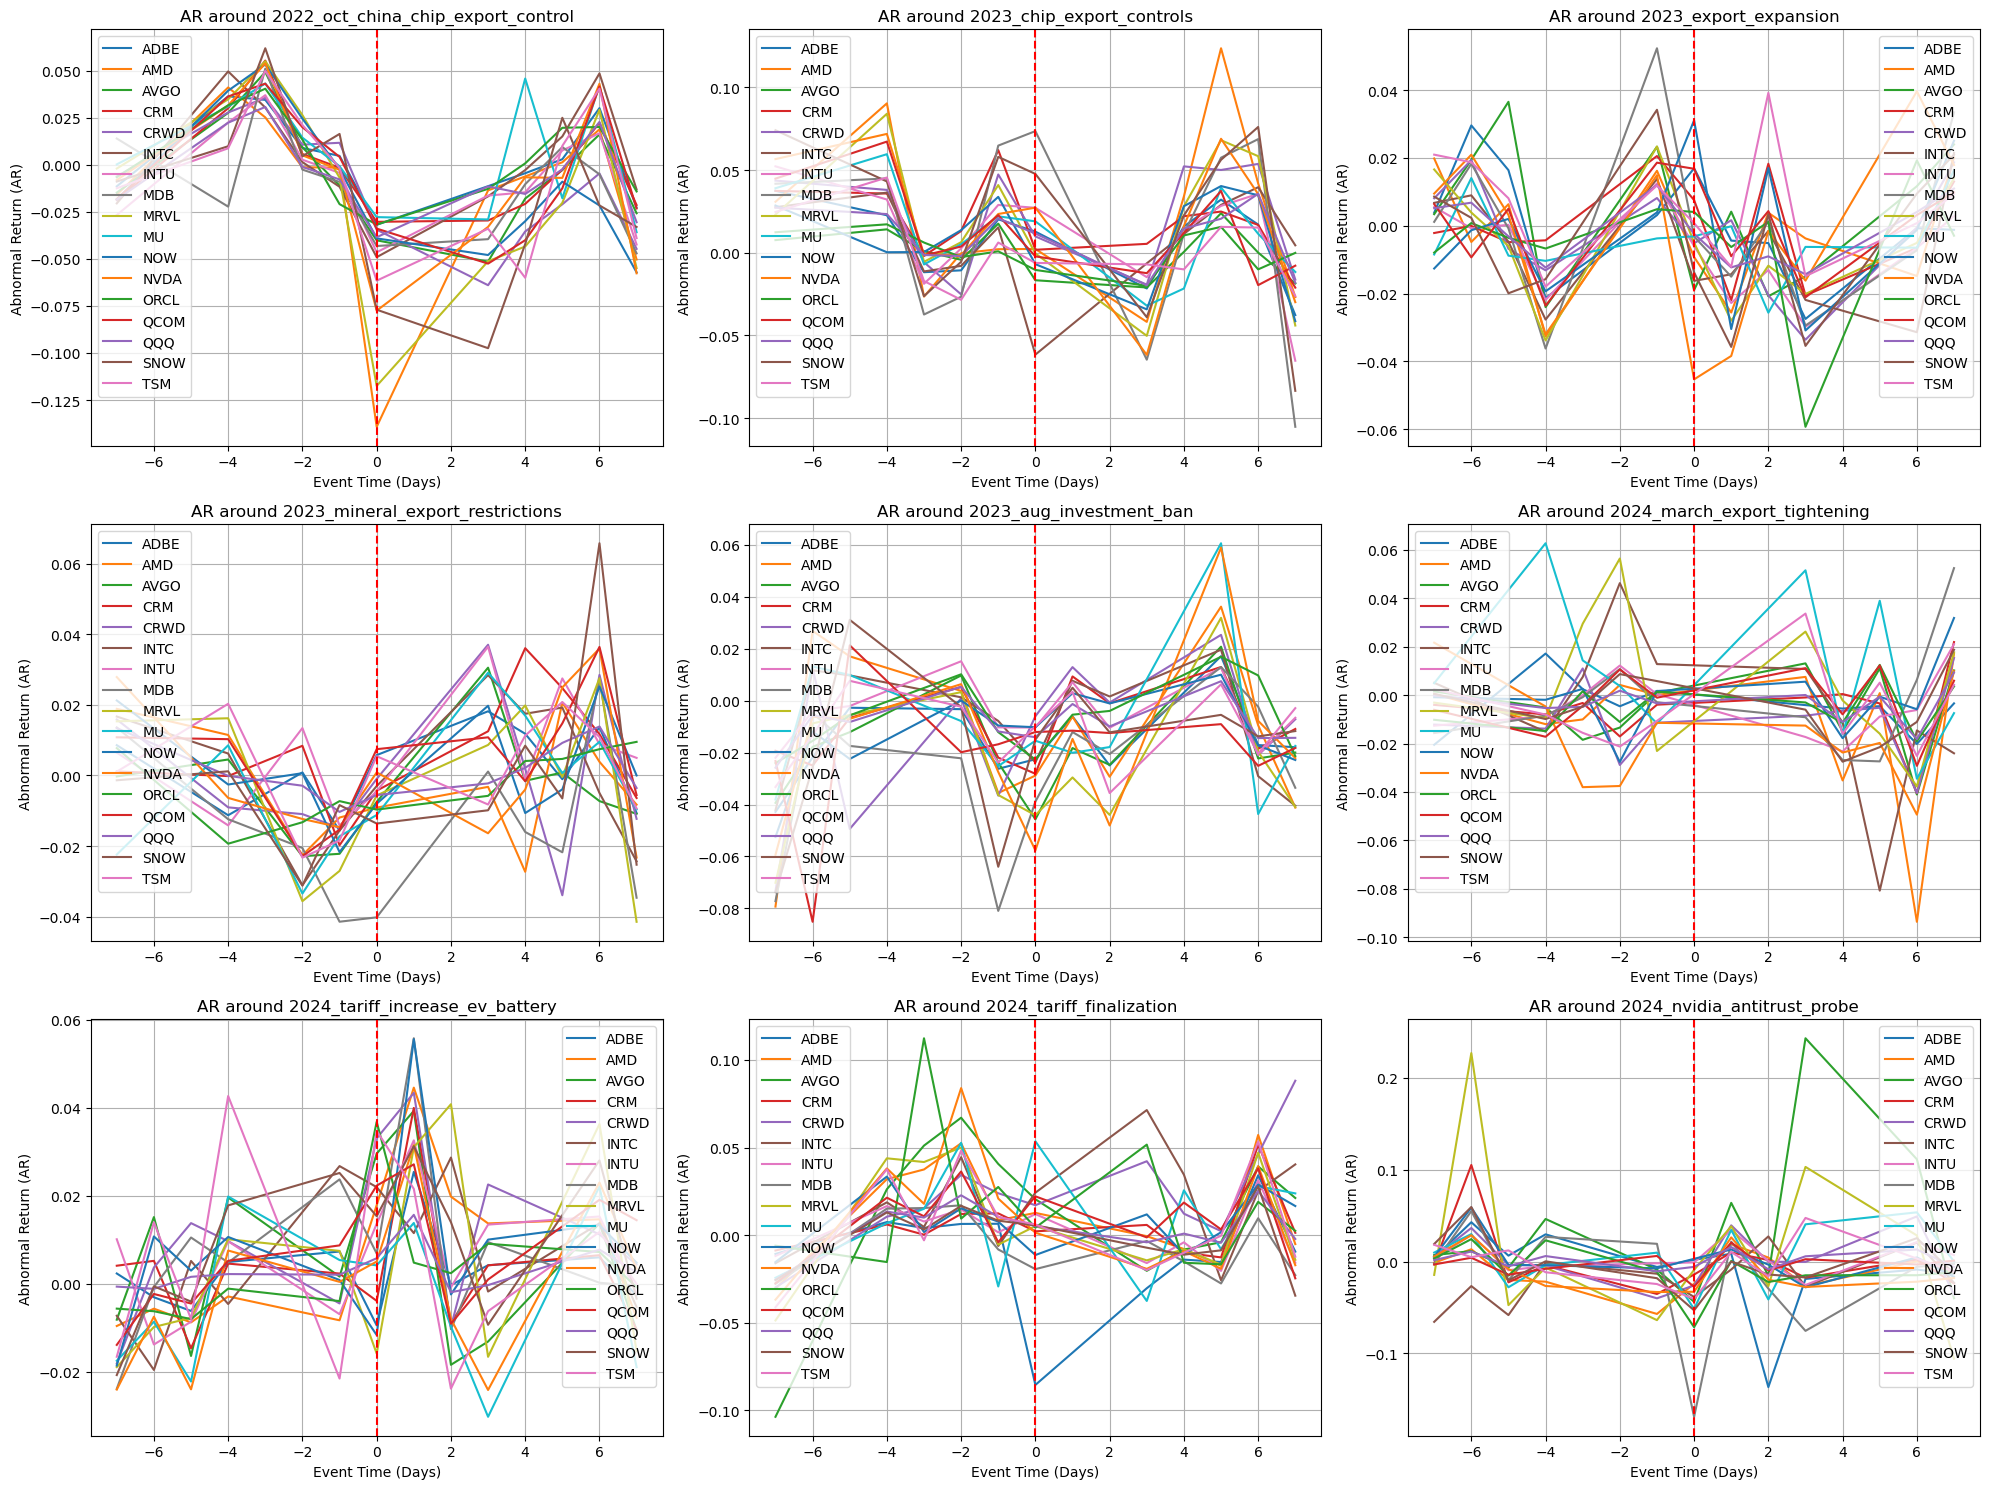

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
data=pd.read_csv("final_df.csv")

all_tickers = sorted(data['ticker'].unique())


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()


for i, (event_id, event_date) in enumerate(event_dict.items()):
    ax = axes[i]
    for ticker in all_tickers:
        sub_df = data[
            (data['event_id'] == event_id) &
            (data['ticker'] == ticker) &
            (data['event_time'].between(-10, 10))
        ].sort_values('event_time')
        sns.lineplot(x='event_time', y='abnormal_return', data=sub_df, label=ticker, ax=ax)

    ax.axvline(0, color='red', linestyle='--')
    ax.set_title(f"AR around {event_id}")
    ax.set_xlabel("Event Time (Days)")
    ax.set_ylabel("Abnormal Return (AR)")
    ax.grid(True)


handles, labels = ax.get_legend_handles_labels()
axes[-1].legend(handles, labels, loc='upper right')


if len(event_dict) < len(axes):
    for j in range(len(event_dict), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


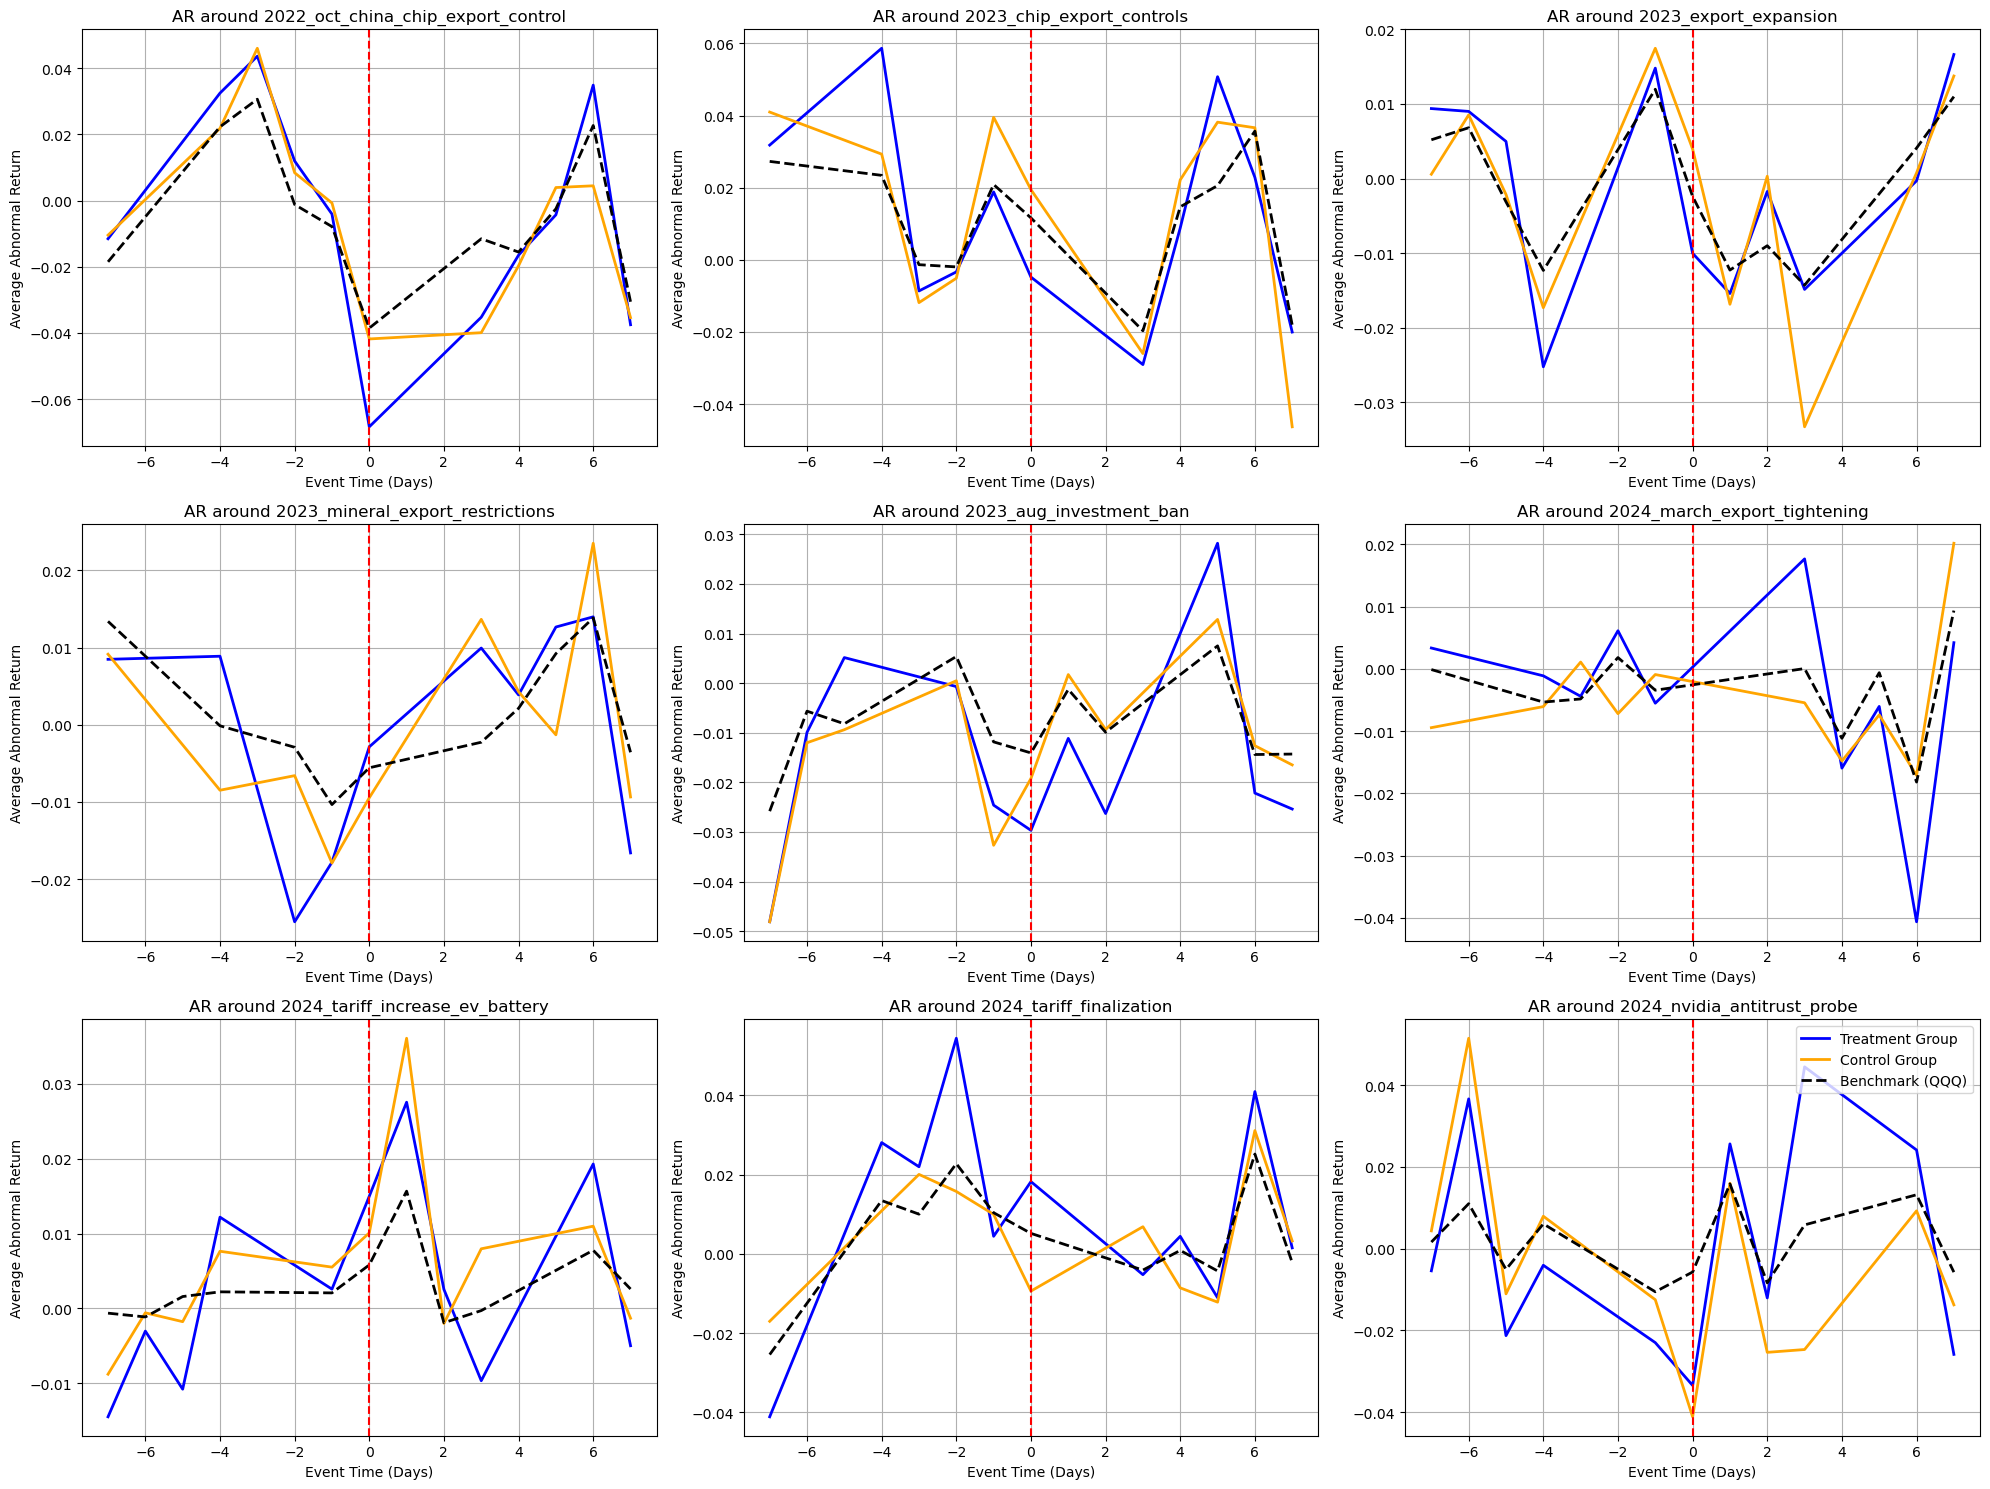

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Load data ===
data = pd.read_csv("final_df.csv")

# === Define groups ===
# Treatment Group (Hardware-dependent AI companies)
treatment_group = ["NVDA", "AMD", "INTC", "MU", "AVGO", "QCOM", "MRVL", "TSM"]

# Control Group (Software/SaaS companies)
control_group = ['CRM','ORCL','ADBE','NOW','CRWD','MDB','INTU','SNOW']

# Benchmark (Market index)
benchmark = "QQQ"

# === Event dictionary ===
# event_dict = {
#     # "2022_oct_china_chip_export_control": pd.to_datetime("2022-10-07"),  # Biden administration restricts advanced AI chip exports to China
#     "2023_chip_export_controls": pd.to_datetime("2023-01-27"),  # US and EU tighten controls on semiconductor technology exports to China
#     "2023_mineral_export_restrictions": pd.to_datetime("2023-07-07"),  # China restricts critical mineral exports
#     "2023_aug_investment_ban": pd.to_datetime("2023-08-09"),  # Biden signs executive order banning investments in Chinese AI/semiconductors
#     "2024_march_export_tightening": pd.to_datetime("2024-03-29"),  # US tightens export licensing rules for AI semiconductors
#     "2024_tariff_increase_ev_battery": pd.to_datetime("2024-05-14"),  # US raises tariffs on EV batteries, solar panels, and metals
#     # "2024_tariff_finalization": pd.to_datetime("2024-09-13"),  # US finalizes higher tariffs
#     "2024_nvidia_antitrust_probe": pd.to_datetime("2024-12-10"),  # China launches antitrust investigation into Nvidia
# }

event_dict = {
    "2022_oct_china_chip_export_control": pd.to_datetime("2022-10-07"),  # Biden administration restricts advanced AI chip exports to China
    "2023_chip_export_controls": pd.to_datetime("2023-01-27"),  # US and EU tighten controls on semiconductor technology exports to China
    "2023_export_expansion": pd.to_datetime("2023-10-17"),  # US expands export restrictions on semiconductors
    
    "2023_mineral_export_restrictions": pd.to_datetime("2023-07-07"),  # China restricts critical mineral exports
    "2023_aug_investment_ban": pd.to_datetime("2023-08-09"),  # Biden signs executive order banning investments in Chinese AI/semiconductors
    "2024_march_export_tightening": pd.to_datetime("2024-03-29"),  # US tightens export licensing rules for AI semiconductors
    "2024_tariff_increase_ev_battery": pd.to_datetime("2024-05-14"),  # US raises tariffs on EV batteries, solar panels, and metals
    "2024_tariff_finalization": pd.to_datetime("2024-09-13"),  # US finalizes higher tariffs
    "2024_nvidia_antitrust_probe": pd.to_datetime("2024-12-10"),  # China launches antitrust investigation into Nvidia
}

# === Plotting setup ===
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for i, (event_id, event_date) in enumerate(event_dict.items()):
    ax = axes[i]
    
    # For this event, extract ±15 days data
    event_df = data[
        (data['event_id'] == event_id) &
        (data['event_time'].between(-15, 15))
    ]

    # Compute group means
    treatment_df = event_df[event_df['ticker'].isin(treatment_group)].groupby('event_time')["abnormal_return"].mean()
    control_df = event_df[event_df['ticker'].isin(control_group)].groupby('event_time')["abnormal_return"].mean()
    benchmark_df = event_df[event_df['ticker'] == benchmark].groupby('event_time')["abnormal_return"].mean()

    # Plot
    treatment_df.plot(ax=ax, label="Treatment Group", color="blue", linewidth=2)
    control_df.plot(ax=ax, label="Control Group", color="orange", linewidth=2)
    benchmark_df.plot(ax=ax, label="Benchmark (QQQ)", color="black", linestyle="--", linewidth=2)

    ax.axvline(0, color='red', linestyle='--')
    ax.set_title(f"AR around {event_id}", fontsize=12)
    ax.set_xlabel("Event Time (Days)")
    ax.set_ylabel("Average Abnormal Return")
    ax.grid(True)

# Global legend
handles, labels = ax.get_legend_handles_labels()
axes[-1].legend(handles, labels, loc='upper right')

# Remove empty subplots
if len(event_dict) < len(axes):
    for j in range(len(event_dict), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


| Comparison Point       | Cross-sectional DiD               | Event-time DiD                          |
|------------------------|-----------------------------------|-----------------------------------------|
| **Time Dimension**     | Focuses on pre/post-event periods | Examines daily effects over the entire event window |
| **Estimation Target**  | A single average treatment effect | Treatment effect at each event time point ($\beta_k$) |
| **Heterogeneity & Dynamics** | No (assumes constant effect)  | Yes (allows treatment effects to vary over time) |
| **Fixed Effects**      | None                              | Includes: firm fixed effects ($\gamma_i$), event fixed effects ($\delta_e$) |
| **Visualization**      | Bar chart or single estimate ($\beta$) | Event-study plot ($\beta_k$ vs. time) |